# Guía 5: Regresiones 

1. Usando el dataset `penguins` del paquete [`palmerpenguins`](https://allisonhorst.github.io/palmerpenguins/), estudiar la relación entre el largo de las aletas de los pinguinos (`flipper_length`) y su peso (`body_mass_g`).
    1.  Proponer un modelo en el que el peso tiene una distribución normal con parámetros $\mu$ y $\sigma$, donde $\mu$ se basa en el largo de las aletas.

    1.  Correr el modelo en STAN usando `brms` o `rstanarm`, eligiendo priors para los parámetros o usando los priors default.

    1.  Diagnosticar las cadenas de muestras de las posteriores para cada parámetro usando el número efectivo de muestras ($n_{eff}$) y $\hat{R}$.

    1.  Encontrar la distribución posterior para el peso esperado de un pinguino que tiene una aleta de largo 200 mm. Graficarla y dar medidas resumen.

    1.  Hacer 500 predicciones del peso de un pinguino con una aleta de largo 200 mm. Graficar la distribución de estos pesos predichos y comparar con el resultado del ítem anterior. ¿A qué se debe la diferencia?

    1.  Graficar 100 rectas correspondientes al peso esperado de pinguinos con una aleta de largo entre 150 mm y 250 mm. Hacer lo mismo para el peso predicho por el modelo.


In [133]:
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as st
import numpy as np


In [2]:

url="https://raw.githubusercontent.com/BayesianModelingandComputationInPython/BookCode_Edition1/main/data/penguins.csv"

df = pd.read_csv(url)
# Subset to the columns needed
missing_data = df.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = df.loc[~missing_data]

print(penguins.columns)

penguins.loc[:, ["flipper_length_mm", "body_mass_g"]].agg(["mean", "std", "count", "max", "min"])

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')


,flipper_length_mm,body_mass_g
mean,200.966967,4207.057057
std,14.015765,805.215802
count,333.000000,333.000000
max,231.000000,6300.000000
min,172.000000,2700.000000


In [10]:

media_largo_aletas = penguins["flipper_length_mm"].mean()
media_largo_aletas

200.96696696696696

Modelo propuesto:

$peso \sim \text{Normal}(\mu, \sigma_p)$

$\mu = \beta_0 + \beta_1 \times {flipper\_length}$


$\mu$ es la media del largo de las aletas (`flipper_length`)

In [44]:


with pm.Model() as modelo:
    largo_aletas = pm.Data("flipper_length", penguins["flipper_length_mm"])

    # sigma = pm.HalfStudentT("sigma_p", 100, 2000)
    sigma = pm.Exponential("sigma_p", 1/1250)
    beta_0 = pm.Normal("beta_0", -1000, 1000)
    beta_1 = pm.Normal("beta_1", 5, 1)

    mu = pm.Deterministic("mu", beta_0 + beta_1 * largo_aletas)


    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=penguins["body_mass_g"].values)

    # prior = pm.sample_prior_predictive(samples=5000)
    # trace = pm.sample(chains=4)
    # inf_data_penguin_mass = az.from_pymc3(prior=prior, trace=trace)

    inf_data_flipper_regression = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_1, beta_0, sigma_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8830785193453303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8976632948740548, but should be close to 0.8. Try to increase the number of tuning steps.


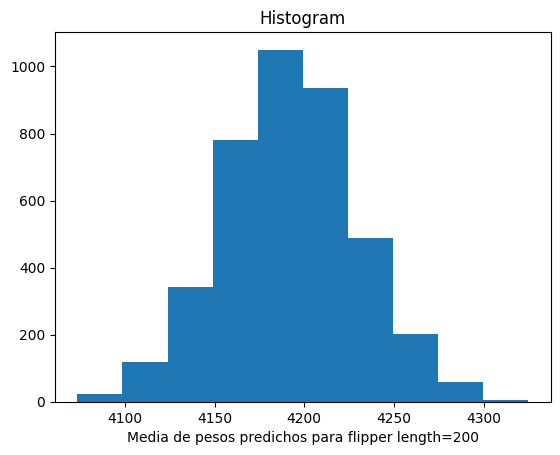

Min: 4073.395652985968 - Max: 4324.972631763865 - N=4000


In [94]:
post = inf_data_flipper_regression.posterior.data_vars

vals = post["beta_0"] + post["beta_1"] * 200

vals.plot.hist()
# plt.hist(vals)
plt.xlabel("Media de pesos predichos para flipper length=200")
plt.show()
print(f"Min: {vals.min().values} - Max: {vals.max().values} - N={len(vals.values.ravel())}")

4000


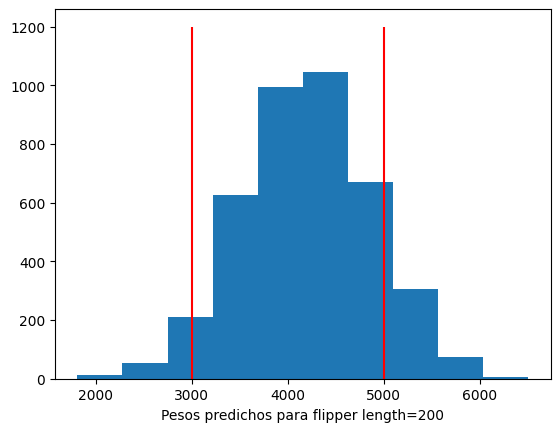

Min: 1811.25 - Max: 6504.71 - N: 4000 


In [145]:
post = inf_data_flipper_regression.posterior.data_vars

mus = post["beta_0"] + post["beta_1"] * 200
sigmas = post["sigma_p"]

mus = mus.values.ravel()
sigmas = sigmas.values.ravel()


# import scipy
# print(scipy.__version__)

data = []
for m,s in zip(mus,sigmas):
    dist = norm(loc=m, scale=s)
    muestra = dist.rvs(1)
    data.append(muestra[0])

int_conf = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

print(len(data))
plt.hist(data)
plt.xlabel("Pesos predichos para flipper length=200")
plt.vlines(3000, 0, 1200, color="red")
plt.vlines(5000, 0, 1200, color="red")
plt.show()
print(f"Min: {round(min(data),2)} - Max: {round(max(data),2)} - N: {len(data)} ")

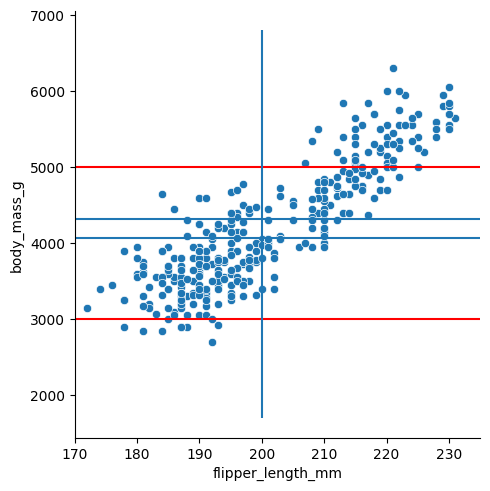

In [144]:
penguins
sns.relplot(data=penguins, x="flipper_length_mm", y="body_mass_g")
plt.hlines(4073, 150, 250)
plt.hlines(4325, 150, 250)
plt.hlines(3000, 150, 250, color="red")
plt.hlines(5000, 150, 250, color="red")
plt.vlines(200, 1700, 6800)
plt.xlim(170, 235)
plt.show()

In [77]:
inf_data_flipper_regression


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data


2. Proponer un modelo de regresión logística para clasificar a un pinguino como de la especie Gentoo usando como variable predictora al largo del pico (`bill_length`).

    1. Correr el modelo y extraer la probabilidad de que un pinguino sea Gentoo si su pico tiene largo 40 mm. (*Ayuda: se puede usar la función `posterior_linpred(transform = TRUE)`*).
    
    1.  Graficar la probabilidad de que un pinguino sea Gentoo en función del largo del pico.

3.  Se quiere entender la relación entre el cociente de ancho y largo del pico ($r$, variable respuesta) y el largo de la aleta (variable explicativa). Proponga un modelo (tenga en cuenta el rango posible de valores de $r$ para elegir la distribución de la variable respuesta). Ajustar el modelo y graficar los valores de $r$ predichos por el modelo para un rango de valores para el largo de la aleta entre 170 mm y 240 mm.